<b>Właściwy kod aplikacji<b>

In [27]:
from skimage import data, io, filters, exposure, measure, color, feature
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib
import pydicom
from pydicom.dataset import Dataset, FileDataset
from pydicom.data import get_testdata_files
import os
import tempfile
import datetime


def addPadding(img):
    result = np.zeros([max(img.shape), max(img.shape)]) if max(img.shape) % 2 == 1 else np.zeros(
        [max(img.shape) + 1, max(img.shape) + 1])
    result[:img.shape[0], :img.shape[1]] = img
    return result


def bresenhamGenerator(x0, y0, x1, y1):
    dx = x1 - x0
    dy = y1 - y0

    xsign = 1 if dx > 0 else -1
    ysign = 1 if dy > 0 else -1

    dx = abs(dx)
    dy = abs(dy)

    if dx > dy:
        xx, xy, yx, yy = xsign, 0, 0, ysign
    else:
        dx, dy = dy, dx
        xx, xy, yx, yy = 0, ysign, xsign, 0

    D = 2*dy - dx
    y = 0

    for x in range(dx + 1):
        yield [x0 + x*xx + y*yx, y0 + x*xy + y*yy]
        if D >= 0:
            y += 1
            D -= 2*dx
        D += 2*dy


def isValidPoint(x, y):
    if x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[0]:
        return True
    else:
        return False


def normalize(vector):
    return [x / max(vector) if max(vector) != 0 and x >= 0 else 0 for x in vector]


def normalizeArray(arr):
    vector = []
    for row in arr:
        vector.extend(row)
    maxValue = max(vector)
    return [x / maxValue if maxValue != 0 and x >= 0 else 0 for x in vector]


def unsharpMasking(vector, mask):
    tmp_vec = vector.copy()
    for i in range(1, len(vector)-1):
        tmp_vec[i] = vector[i]*mask[1] + vector[i-1] * \
            mask[0] + vector[i+1] * mask[2]
    return normalize(tmp_vec)


def getValues(emitter, detectors):
    values = []
    for det in detectors:
        value = 0
        processedPixels = 0
        for i in bresenhamGenerator(emitter[0], emitter[1], det[0], det[1]):
            if isValidPoint(i[0], i[1]):
                value += img[i[0], i[1]]
                processedPixels += 1
                if debug:
                    markedImg[i[0], i[1]] = 1
        if processedPixels != 0:
            values.append(np.float64(value / processedPixels))
        else:
            values.append(np.float64(0))
    return values


def getPositions(angDeg, detectors, detectorsAngle):
    ang = np.deg2rad(angDeg)
    positions = []
    r = img.shape[0] * np.sqrt(2) / 2
    center = int(img.shape[0] / 2)
    positions.append([int(r * np.cos(ang)) + center,
                      int(r * np.sin(ang)) + center])
    if detectors > 1:
        for i in range(detectors):
            position = [int(r * np.cos(ang + np.pi - detectorsAngle / 2 + i * detectorsAngle / (detectors - 1))) + center,
                        int(r * np.sin(ang + np.pi - detectorsAngle / 2 + i * detectorsAngle / (detectors - 1))) + center]
            positions.append(position)
    return positions


def getSinogram(detectors, detectorsAngle, iterations):
    sinogram = []
    angles = np.linspace(0., 360., iterations, endpoint=False)
    for ang in angles:
        positions = getPositions(ang, detectors, detectorsAngle)

        values = getValues(positions[0], positions[1:])
        sinogram.append(values)
    return sinogram


def getInverse(sinogram, iterations, detectorsAngle, filtered):
    angles = np.linspace(0., 360., iterations, endpoint=False)
    image = [[0 for i in range(img.shape[0])] for j in range(img.shape[0])]

    def addValue(emitter, detectors, values):
        for det in range(len(detectors)):
            for i in bresenhamGenerator(emitter[0], emitter[1], detectors[det][0], detectors[det][1]):
                if isValidPoint(i[0], i[1]):
                    image[i[0]][i[1]] += values[det]

    for i in range(iterations):
        positions = getPositions(angles[i], detectors, detectorsAngle)
        col = sinogram[:, i] if filtered else unsharpMasking(
            sinogram[:, i], [-2, 5, -2])
        addValue(positions[0], positions[1:], col)

    normalizeArray(image)

    return image


def writeDicom(image, name, comment, sex, birthDate):
    filename = get_testdata_files("CT_small.dcm")[0]
    ds = pydicom.dcmread(filename)

    def normalizeInDicom(image_temp):
        maximum = 0
        for vector in image_temp:
            if max(vector) > maximum:
                maximum = max(vector)
        for i in range(len(image_temp)):
            for x in range(len(image_temp[0])):
                if maximum != 0 and image_temp[i][x] > 0:
                    image_temp[i][x] = image_temp[i][x]*1024/maximum
                else:
                    image_temp[i][x] = 0
        return image_temp

    image = normalizeInDicom(image)
    image2 = np.asarray(image, dtype=np.uint16)
    ds.Rows = image2.shape[1]
    ds.Columns = image2.shape[0]
    ds.PixelData = image2.tostring()
    ds.PatientName = name
    ds.InstitutionName = 'Politechnika Poznanska'
    ds.Manufacturer = 'Politechnika Poznanska'
    ds.PatientSex = sex
    ds.PatientBirthDate = birthDate
    dt = datetime.datetime.now()
    ds.StudyDate = dt.strftime('%Y%m%d')
    timeStr = dt.strftime('%H%M%S.%d')
    ds.StudyTime = timeStr
    ds.AdditionalPatientHistory = comment
    ds.save_as("Tomograf_DICOM.dcm")


def readDicom(filename):
    ds = pydicom.dcmread(filename)
    return ds


def drawSinogram(detectors, detectorsAngle, iterations):
    detectorsAngle = 2 * np.deg2rad(detectorsAngle)
    # Zmnienna do której przypisywana będzie nazwa wczytywanego pliku
    filename = "Tomograf_DICOM.dcm"
    if debug:
        markedImg = img.copy()

    sinogram = np.array(getSinogram(
        detectors, detectorsAngle, iterations)).transpose()
    image = getInverse(sinogram, iterations, detectorsAngle, True)

    mse = np.square(np.subtract(img, image)).mean()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    if debug:
        ax1.set_title("Image - scanned pixel marked")
        ax1.imshow(markedImg, cmap=plt.cm.Greys_r)
    else:
        ax1.set_title("Original image")
        ax1.imshow(img, cmap=plt.cm.Greys_r)

    # writeDicom(image, "Imie Nazwisko", "Komentarz", 'M', '19970912') #tu trzeba podstawić zmienne z danymi pacjenta
    # ds = readDicom(filename)

    if debug:
        print('Img:\n', img)
        print('Sinogram:\n', sinogram)
        print('Sinogram dimensions: ', len(sinogram), ', ', len(sinogram[0]))

    ax2.set_title("Sinogram")
    ax2.set_xlabel("Iteration number")
    ax2.set_ylabel("Detector number")
    ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

    ax3.set_title("Sinogram (mask)")
    ax3.set_xlabel("Iteration number")
    ax3.set_ylabel("Detector number")
    ax3.imshow([unsharpMasking(vector, [-2, 5, -2])
                for vector in sinogram], cmap=plt.cm.Greys_r)

    # ax4.imshow(ds.pixel_array,cmap=plt.cm.Greys_r) # Wczytany plik
    # Informacje do wyświetlenia to:
    # ds.PatientName = name
    # ds.PatientSex
    # ds.PatientBirthDate
    # ds.StudyDate
    # ds.StudyTime
    # ds.AdditionalPatientHistory
    ax4.set_title("Inverse Radon transform result")
    ax4.imshow(image, cmap=plt.cm.Greys_r)

    plt.show()


def animateSinogram(detectors, detectorsAngle, iterations):
    detectorsAngle = 2 * np.deg2rad(detectorsAngle)
    angles = list(np.linspace(0., 360., 10, endpoint=False))
    angles.insert(0, 0.)
    angles = [2 * int(angle) for angle in angles]

    aniFig, (axImg, axAni, axSin) = plt.subplots(1, 3, figsize=(10, 10))

    sinogram = np.array(getSinogram(
        detectors, detectorsAngle, iterations)).transpose()
    blankSinogram = np.zeros([sinogram.shape[0], sinogram.shape[1]])

    def init():
        axImg.set_title("Original image")
        axImg.imshow(img, cmap=plt.cm.Greys_r)

        axAni.tick_params(axis='x', )
        axAni.set_title("Sinogram animation")
        axAni.set_xlabel("Rotation angle")
        axAni.set_ylabel("Detector number")
        axAni.xaxis.set_major_formatter(
            matplotlib.ticker.FixedFormatter(angles))
        # axAni.locator_params(axis='x', nbins=7)
        axAni.imshow(blankSinogram, cmap=plt.cm.Greys_r)

        axSin.set_title("Sinogram")
        axSin.set_xlabel("Iteration number")
        axSin.set_ylabel("Detector number")
        axSin.imshow(sinogram, cmap=plt.cm.Greys_r)

        return aniFig

    def update(time):
        blankSinogram[:, time] = sinogram[:, time]
        axAni.imshow(blankSinogram, cmap=plt.cm.Greys_r)
        return aniFig

    ani = FuncAnimation(aniFig, update,  np.linspace(
        0, iterations, iterations).astype(int), init_func=init, interval=1.)
    plt.show()


def animateInverse(detectors, detectorsAngle, iterations):
    detectorsAngle = 2 * np.deg2rad(detectorsAngle)

    sinogram = np.array(getSinogram(
        detectors, detectorsAngle, iterations)).transpose()
    image = getInverse(sinogram, iterations, detectorsAngle, 0)
    blankImg = np.zeros([img.shape[0], img.shape[1]])

    aniFig, ((axSin, axAni), (axImg, axImgInv)
             ) = plt.subplots(2, 2, figsize=(10, 10))

    def init():
        axImg.set_title("Original image")
        axImg.imshow(img, cmap=plt.cm.Greys_r)

        axAni.tick_params(axis='x', )
        axAni.set_title("Inverse transform animation")
        axAni.imshow(blankImg, cmap=plt.cm.Greys_r)

        axSin.set_title("Sinogram")
        axSin.set_xlabel("Iteration number")
        axSin.set_ylabel("Detector number")
        axSin.imshow(sinogram, cmap=plt.cm.Greys_r)

        axImgInv.set_title("Inverse transform result")
        axImgInv.imshow(image, cmap=plt.cm.Greys_r)

        return aniFig

    def update(time):
        blankImg[time] = image[time]
        axAni.imshow(blankImg, cmap=plt.cm.Greys_r)
        return aniFig

    size = img.shape[0]

    ani = FuncAnimation(aniFig, update,  np.linspace(
        0, size, size).astype(int), init_func=init, interval=1.)
    plt.show()


# Różne przykładowe zdjęcia do testowania
# img = addPadding(data.imread("mozg_inverted_400.png", as_gray=True))
img = addPadding(data.imread("slp256.png", as_gray=True))
# img = addPadding(np.zeros([512, 512], dtype=np.uint8))
# img = addPadding(np.zeros([40, 40], dtype=np.uint8))
# img[0, 20] = 1
# img[10,25] = img[11,27] = img[12, 29] = 0.5
# img[10,26] = img[11,26] = img[12, 27] = 0.25

# n - ilość detektorów
detectors = 120
# l (deg) - kąt między skrajnymi detektorami przy emiterze
detectorsAngle = 90
# Ilość pomiarów
iterations = 120
# Zaznaczanie odwiedzonych, printy itd.
debug = False

# drawSinogram(detectors, detectorsAngle, iterations)
# animateSinogram(detectors, detectorsAngle, iterations)
# animateInverse(detectors, detectorsAngle, iterations)


<b>Sterowanie za pomocą suwaków<b>

In [22]:
from ipywidgets import *
img = addPadding(data.imread("slp256.png", as_gray=True))
# img = addPadding(data.imread("mozg_200.png", as_gray=True))
interact(drawSinogram, detectors=(120, 180, 1), detectorsAngle=(10, 90, 1), iterations=(2, 150, 1))
# interact(drawSinogram, detectors=(120, 120, 1), detectorsAngle=(90, 90, 1), iterations=(120, 120, 1))

interactive(children=(IntSlider(value=150, description='detectors', max=180, min=120), IntSlider(value=50, des…

<function __main__.drawSinogram(detectors, detectorsAngle, iterations)>

<b>Animacje<b>

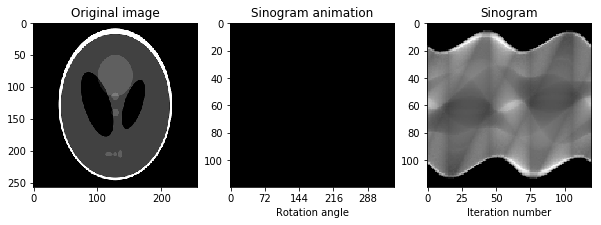

In [19]:
img = addPadding(data.imread("slp256.png", as_gray=True))
# n - ilość detektorów
detectors = 120
# l (deg) - kąt między skrajnymi detektorami przy emiterze
detectorsAngle = 90
# Ilość pomiarów
iterations = 120
# Zaznaczanie odwiedzonych, printy itd.
debug = False

animateSinogram(detectors, detectorsAngle, iterations)
# animateInverse(detectors, detectorsAngle, iterations)

<b>DICOM - dane pacjenta<b>

In [24]:
name = 'Adam Nowak'
comment = 'Przykladowy komentarz'
sex = 'M'
birthDate = '19900123'

Imie pacjenta: Adam Nowak
Plec pacjenta: M
Data urodzenia pacjenta: 1990 01 23
Data badania: August 22, 1970 05:25:24
Dodatkowy komentarz: Przykladowy komentarz


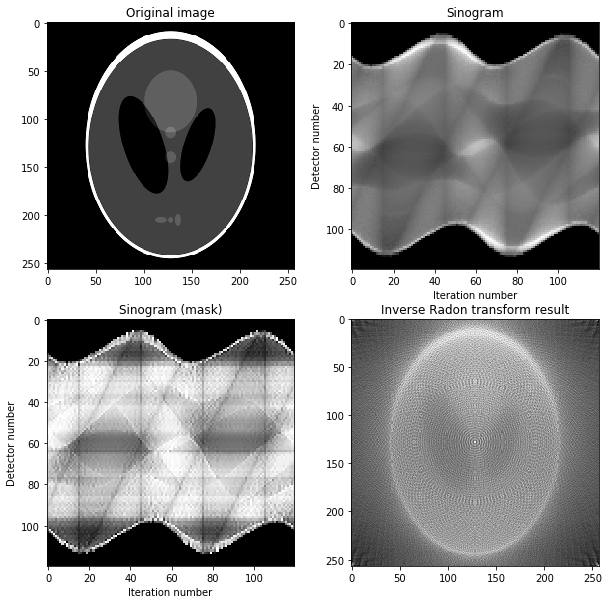

In [45]:
import datetime

def drawSinogram(detectors, detectorsAngle, iterations):
    detectorsAngle = 2 * np.deg2rad(detectorsAngle)
    # Zmnienna do której przypisywana będzie nazwa wczytywanego pliku
    filename = "Tomograf_DICOM.dcm"
    if debug:
        markedImg = img.copy()

    sinogram = np.array(getSinogram(
        detectors, detectorsAngle, iterations)).transpose()
    image = getInverse(sinogram, iterations, detectorsAngle, True)

    mse = np.square(np.subtract(img, image)).mean()

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

    if debug:
        ax1.set_title("Image - scanned pixel marked")
        ax1.imshow(markedImg, cmap=plt.cm.Greys_r)
    else:
        ax1.set_title("Original image")
        ax1.imshow(img, cmap=plt.cm.Greys_r)

    writeDicom(image, name, comment, sex, birthDate)
    ds = readDicom(filename)

    if debug:
        print('Img:\n', img)
        print('Sinogram:\n', sinogram)
        print('Sinogram dimensions: ', len(sinogram), ', ', len(sinogram[0]))

    ax2.set_title("Sinogram")
    ax2.set_xlabel("Iteration number")
    ax2.set_ylabel("Detector number")
    ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

    ax3.set_title("Sinogram (mask)")
    ax3.set_xlabel("Iteration number")
    ax3.set_ylabel("Detector number")
    ax3.imshow([unsharpMasking(vector, [-2, 5, -2])
                for vector in sinogram], cmap=plt.cm.Greys_r)

    
    print('Imie pacjenta:', ds.PatientName)
    print('Plec pacjenta:', ds.PatientSex)
    print('Data urodzenia pacjenta:', ds.PatientBirthDate[0:4], ds.PatientBirthDate[4:6], ds.PatientBirthDate[6:8])
    print('Data badania:', datetime.datetime.fromtimestamp(int(ds.StudyDate)).strftime("%B %d, %Y %I:%M:%S"))
    print('Dodatkowy komentarz:', ds.AdditionalPatientHistory)
    
    ax4.set_title("Inverse Radon transform result")
    ax4.imshow(image, cmap=plt.cm.Greys_r)

    plt.show()
    
    
    
img = addPadding(data.imread("slp256.png", as_gray=True))
detectors = 120
detectorsAngle = 90
iterations = 120

drawSinogram(detectors, detectorsAngle, iterations)

